Import

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import  SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

Define data types

In [2]:
dtype_dict = {
    'id': int,
    'title_fa': str,
    'Rate': float,
    'Rate_cnt': int,
    'Category1': str,
    'Category2': str,
    'Brand': str,
    'Price': float,
    'Seller': str,
    'Is_Fake': str,
    'min_price_last_month': float,
    'sub_category': str
}

load data

In [3]:
data = pd.read_csv('//workspaces//Digikala_Recommended_System//digikala.csv', dtype=dtype_dict)


In [4]:

data["Category1"] = data["Category1"].astype(str)
data["Category2"] = data["Category2"].astype(str)

data = data[[ "id", "title_fa", "Rate", "Rate_cnt", "Category1", "Category2", "Brand", "Price", "sub_category" ]]

data.fillna(0, inplace=True)

Lable encoder

In [5]:
label_encoder_cate1 = LabelEncoder()
label_encoder_cate2 = LabelEncoder()
data['Category1_encoded'] = label_encoder_cate1.fit_transform(data['Category1'])
data['Category2_encoded'] = label_encoder_cate2.fit_transform(data['Category2'])

In [6]:
features = data[["Category1_encoded", "Category2_encoded","Price", "Rate"] ] 

In [7]:
titles = data[["title_fa"]]

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(features, titles, test_size=0.2, random_state=42)

visualization


In [8]:
mean_rates = data.groupby("sub_category")["Rate"].mean()
mean_rates2 = data.groupby("Category1")["Rate"].mean()

In [9]:
list_colors = ['blue', 'red', 'green', 'yellow', 'black', 'white']

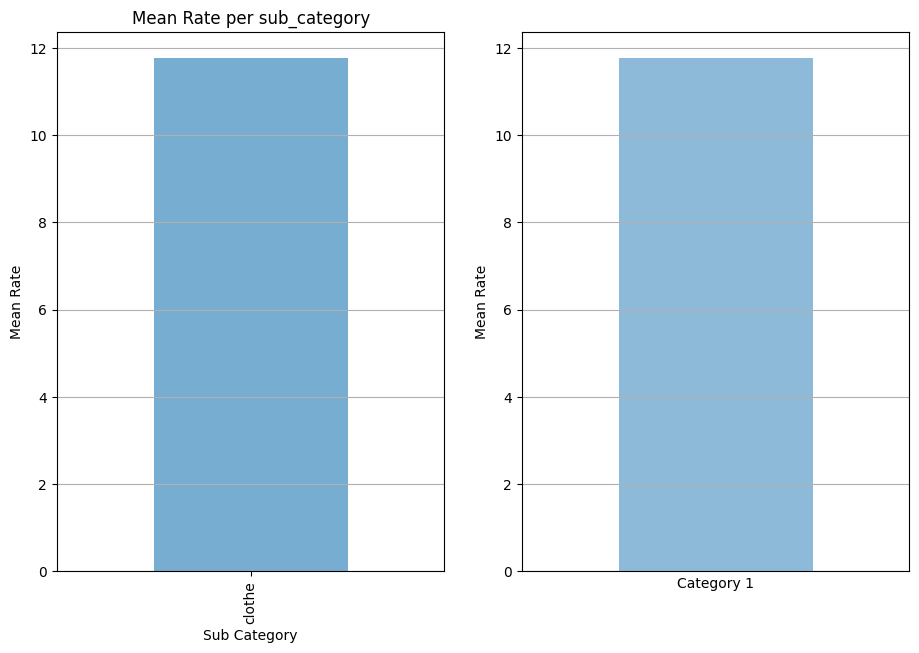

In [10]:
plt.figure(figsize=(11, 7))
plt.subplot(1, 2, 1)
plt.title("Mean Rate per sub_category")
mean_rates.plot(kind='bar',  alpha=0.6)
plt.xlabel("Sub Category")
plt.ylabel("Mean Rate")
plt.xticks()
plt.grid(axis='y')
plt.subplot(1, 2, 2)
mean_rates2.plot(kind='bar', alpha=0.5)
plt.xlabel("Category 1")
plt.ylabel("Mean Rate")
plt.xticks([])
plt.grid(axis='y')
plt.show()

make it standard to show

In [11]:
colors = plt.cm.viridis(data["Rate_cnt"] / max(data["Rate_cnt"]))


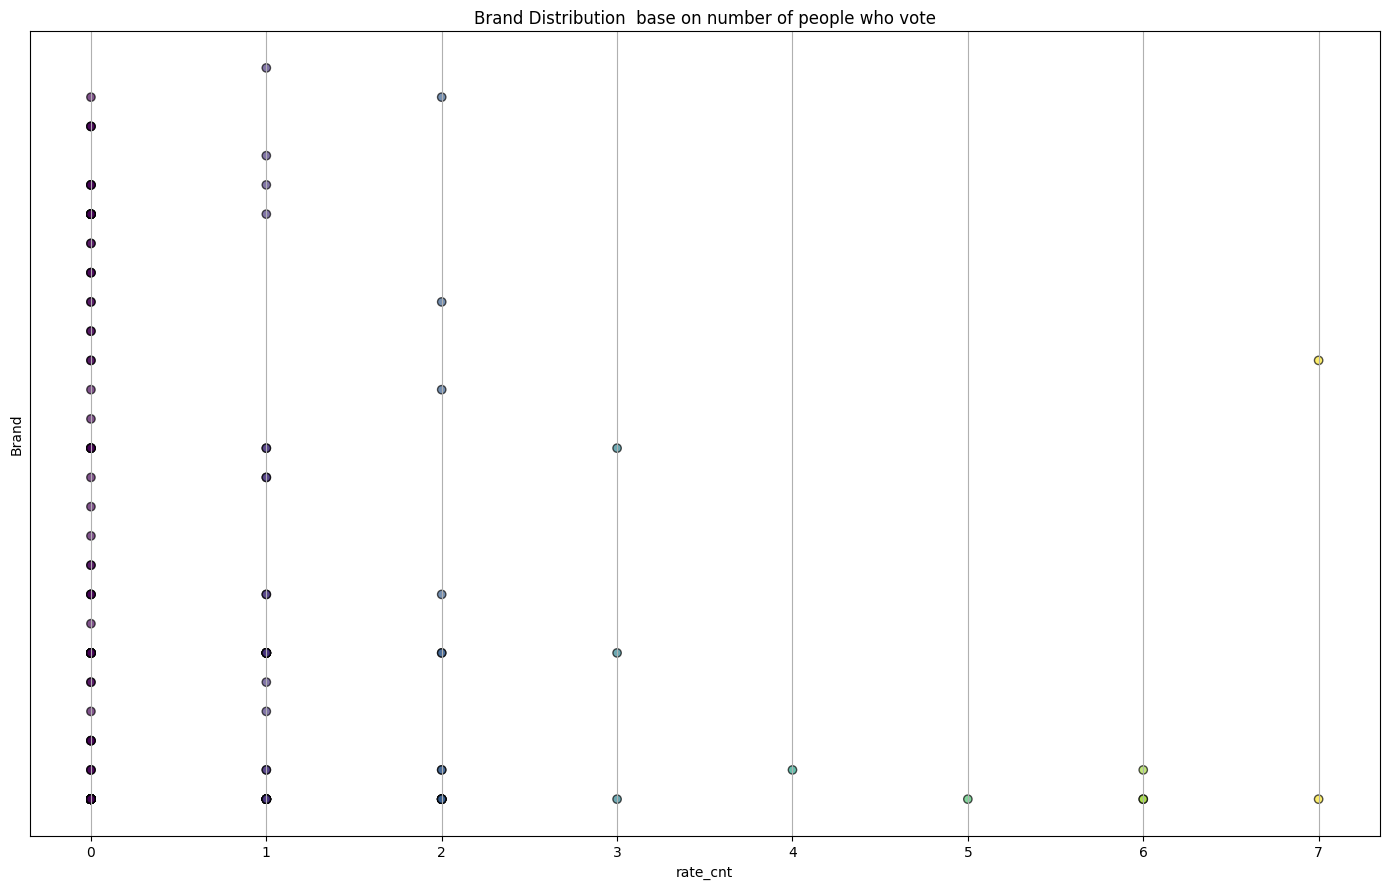

In [12]:
plt.figure(figsize=(14, 9))
plt.scatter(data["Rate_cnt"], data["Brand"], color=colors, edgecolors='black',alpha=0.68)

plt.title("Brand Distribution  base on number of people who vote")
plt.xlabel("rate_cnt")
plt.ylabel("Brand")

plt.grid(axis='x')
plt.xticks()
plt.yticks([])
plt.tight_layout()
plt.show()

start working with sklearn

Standard scale

In [13]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# X_test = features_scaled2 = scaler.fit_transform(X_test)

Creat model

In [14]:
model = NearestNeighbors(n_neighbors=10, algorithm='auto')
model.fit(features_scaled)

NearestNeighbors(n_neighbors=10)

function define

In [15]:
def recommended(input_title,  model = model, data=data, n_sample = 5):
    product_info = data.loc[data["title_fa"]== input_title]
    if product_info.empty:
            print(f"محصول با عنوان {input_title} پیدا نشد.")
            return pd.DataFrame()    
    input_features = product_info[["Category1_encoded", "Category2_encoded", "Price", "Rate"]]
    
    input_features_scaled = scaler.transform(input_features)
    
    distances, indices = model.kneighbors(input_features_scaled)
    similar_products = data.iloc[indices[0]]
    
    if len(similar_products) > n_sample:
        similar_products = similar_products.sample(n=n_sample, random_state=np.random.randint(1000))
    similar_products = similar_products[similar_products['title_fa'] != input_title]
    return similar_products

In [17]:
def user_recommendations():
    # Load data
    import pandas as pd
    data2 = pd.read_excel("//workspaces//Digikala_Recommended_System//keifiat.xlsx")
    pd.set_option('display.max_columns', None)

    data2['user_id'] = data2['user_id'].astype(str)
    data2['product_id'] = data2['product_id'].astype(str)
    data2['user_id'] = data2['user_id'].str.strip()
    data2['product_id'] = data2['product_id'].str.strip()

    # Handle missing values
    data2.dropna(subset=['user_id', 'product_id', 'title_en', 'recommend'], inplace=True)
    data2 = data2[data2['recommend'] != '\\N']
    data2 = data2[data2['recommend'] != 'no_idea']

    # Encode 'user_id', 'product_id', and 'title_en'
    label_encoder_user = LabelEncoder()
    label_encoder_product = LabelEncoder()
    label_encoder_recommend = LabelEncoder()
    label_encoder_title_en = LabelEncoder()

    data2['user_id_encoded'] = label_encoder_user.fit_transform(data2['user_id'])
    data2['product_id_encoded'] = label_encoder_product.fit_transform(data2['product_id'])
    data2['recommend_encoded'] = label_encoder_recommend.fit_transform(data2['recommend'])
    data2['title_en_encoded'] = label_encoder_title_en.fit_transform(data2['title_en'])

    # Define features and target variable
    features = data2[['user_id_encoded', 'product_id_encoded', 'title_en_encoded']]
    target = data2['recommend_encoded']
    # scaler = StandardScaler()  if use MLP do scaler but not for Random forest
    # features = scaler.fit_transform(features)
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)
    # print(data2.to_string())
    """
    # Define parameter grids for models
    param_grid_rf = {
        'n_estimators': [80, 200, 300],
        'max_features': [2, 3],
        'min_samples_split': [2, 3, 4],
        'class_weight': ['balanced']
    }

    param_grid_dt = {
        'max_features': [2, 3],
        'min_samples_split': [2, 3, 4],
        'class_weight': ['balanced']
    }

    param_grid_svc = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }"""
    # Create and train Random Forest model
    rf_model = RandomForestClassifier(max_features=3, min_samples_split=2,random_state=42 ,class_weight="balanced",min_samples_leaf=20, n_estimators=150)
    rf_model.fit(X_train, y_train)
    # 
    # from imblearn.over_sampling import SMOTE
    # 
    # # توازن داده‌ها با SMOTE
    # smote = SMOTE(random_state=42)
    # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # 
    # mlp_model = MLPClassifier(hidden_layer_sizes=(16,16,16), max_iter=10000)
    # mlp_model.fit(X_train_resampled, y_train_resampled)
   


    # Evaluate model
    y_pred = rf_model.predict(X_test)
    # y_pred_mlp = mlp_model.predict(X_test)
  
    print("-------------------------------------",y_pred)
    f1_rf = f1_score(y_test, y_pred)
    # f1_mlp = f1_score(y_test, y_pred_mlp)


    print(f1_rf)
    # print(f1_mlp)
    
    print(classification_report(y_test, y_pred))
    # print(classification_report(y_test, y_pred_mlp))

    # print(data2[['user_id', 'user_id_encoded', 'product_id', 'product_id_encoded','title_en', 'title_en_encoded', 'recommend',
    #              'recommend_encoded']].head(10))
    # Predict for new products
    user_id = input("لطفا شناسه کاربری خود را وارد کنید: ")
    product_id = input("لطفا شناسه محصول را وارد کنید: ")

    # Check if user_id and product_id exist in the data
    if user_id not in data2['user_id'].values:
        raise ValueError(f"شناسه کاربر {user_id} یافت نشد.")
    if product_id not in data2['product_id'].values:
        raise ValueError(f"شناسه محصول {product_id} یافت نشد.")

    # Encode the new user_id and product_id
    user_id_encoded = label_encoder_user.transform([user_id])
    product_id_encoded = label_encoder_product.transform([product_id])

    # Get the title_en_encoded for the specific product (assumed to be the first match)
    title_en_encoded = data2.loc[(data2['product_id'] == product_id) , 'title_en_encoded'].values[0]

    # Create new DataFrame for prediction
 # Create new DataFrame for prediction
    new_data = pd.DataFrame({
        'user_id_encoded': user_id_encoded,
        'product_id_encoded': product_id_encoded,
        'title_en_encoded': [title_en_encoded]
    })

# Transform new data to ensure it is a DataFrame

    # new_data = new_data.values

    # Predict recommendation
    # new_data_scaled = scaler.transform(new_data)  if use mlp
    
    recommendation_prediction =rf_model.predict(new_data)
    
    recommendation_label = label_encoder_recommend.inverse_transform(recommendation_prediction)

    print(new_data)
    print(f"توصیه برای محصول {product_id} به کاربر {user_id}: {recommendation_label[0]}")
   


In [25]:
user_recommendations()



------------------------------------- [1 1 0 ... 1 1 1]
0.704337899543379
              precision    recall  f1-score   support

           0       0.39      0.47      0.43      1636
           1       0.74      0.67      0.70      3673

    accuracy                           0.61      5309
   macro avg       0.56      0.57      0.57      5309
weighted avg       0.63      0.61      0.62      5309

   user_id_encoded  product_id_encoded  title_en_encoded
0             1944               29097                14
توصیه برای محصول 80708 به کاربر 1289964: recommended


In [19]:
input_title = input("عنوان محصول خود را وارد کنید: ")
output = recommended(input_title)


In [24]:
if not output.empty:
    print(f"\nمحصولات پیشنهادی بر اساس '{input_title}':")
    print(output[['title_fa', 'Brand', 'Price', 'Category1']])
else:
    print("هیچ توصیه‌ای برای نمایش وجود ندارد.")




محصولات پیشنهادی بر اساس 'عینک آفتابی مدل C125c2':
                                       title_fa   Brand      Price  \
105                 عینک آفتابی میباخ مدل MYC33   میباخ  5500000.0   
96                 عینک آفتابی مدل XH3332 - فشن  متفرقه  5490000.0   
0              عینک آفتابی مدل 3548 - Fnok شیشه  متفرقه  5500000.0   
108    عینک آفتابی مدل ML6026 Tawny Transparent  متفرقه  5450000.0   
127  عینک آفتابی مدل ML6012 Transparent Apricot  متفرقه  5450000.0   

                  Category1  
105  اکسسوری زنانه و مردانه  
96   اکسسوری زنانه و مردانه  
0    اکسسوری زنانه و مردانه  
108  اکسسوری زنانه و مردانه  
127  اکسسوری زنانه و مردانه  
